# P5 Vision and PDDL

[Instructions are the same as they've been.]

## P5.1 Feature Matching with OpenCV [8 points]

In class, I showed you a demo of OpenCV and how sparse features could be used to locate a reference object "in the wild".

**TASK** Follow the [OpenCV tutorial](https://docs.opencv.org/master/d1/de0/tutorial_py_feature_homography.html) to implement feature matching (copy-pasting code is expected here) and confirm to yourself that 

Next, you will do this on an object of your own!

**TASK** Find a *flat* object (a textbook with an interesting cover image is great for this) and take a clear reference photo of it. Crop that image and load it into python. Here's a reasonable function to load the image:

```python
from PIL import Image
import numpy as np

def load_image(filepath):
    img = Image.open(filepath)
    return (np.asarray(img).astype(float)/255)[:, :, :3]
```

**TASK** Take a few (3 or more) pictures of the object in different places or angles (and perhaps also lighting conditions) around your home or desk; feel free to try to fool the detector in one or two images, but try to show at least one where the matching works quite well. Run the OpenCV code from before to see if you can match features between the reference image and the others.

**IMAGES** Show the OpenCV feature matching code for your reference image compared to (at least) three others.

**RESPONSE** (3-6 sentences) Using your images, describe some of the features (parts of the image) or lighting/orientation conditions that work well and some that do not. Your response does not need to be detailed; I'm just looking to see that you've scrutinized your results.

**FIGURE & DISCUSSION** Generate an image like the one in the tutorial but for the two transformed sunflower images I have included. How does the performance (e.g., in terms of the number of features or accuracy of matches) of the OpenCV system compare to the system you implemented? How much faster (roughly, I do not need a precise number) is the OpenCV system compared to yours?

In [55]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
MIN_MATCH_COUNT = 10
img1 = cv.imread('11.png',0)          # queryImage
img2 = cv.imread('331.png',0) # trainImage
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
print(len(good))

33


In [56]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

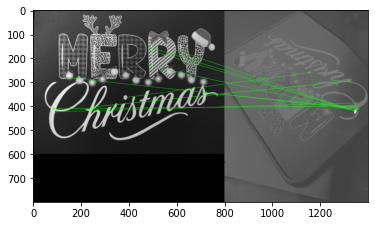

(<matplotlib.image.AxesImage at 0x7f4f0be67ed0>, None)

In [57]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

## P5.2: Structure from Motion with COLMAP [4 points]

COLMAP is a package for Structure from Motion: the aim of which is to build a 3D map of sparse features from a video or series of images from a scene. I would now like you to try it here on your own video to build a 3D reconstructed scene. First, you should [download COLMAP](https://colmap.github.io/install.html). I highly recommend you download one of the standalone executables, since then you do not have to worry about building the library yourself.

> A note for MacOS users: the newest version(s) of COLMAP did not work for me on my machine. I went back and download version 3.4 and that worked fine.

Create a new folder that will serve as your COLMAP workspace. Record a video of a small scene on your phone and move it into the folder you have just created. To build a 3D scene, you will need to extract individual frames from the video; for this I recommend using the open-source tool [ffmpeg](http://ffmpeg.org). With it, extracting frames is relatively easy. For example, at the command line:

```
cd colmap_demo
mkdir images
ffmpeg -i my_workspace.MOV -vf fps=3 \
    images/frame%04d.jpg -hide_banner
```

Note that I have used `fps=3` to indicate that I would only like to extract 3 images per second of video. No more than this should be necessary here.

Now open COLMAP and navigate to `Reconstruction -> Automatic reconstruction` and populate the boxes:
- Workspace folder: select a folder where the output will be stored;
- Image folder: where you extracted your video frames;
- Under `Data type` you can leave it as the default: `Individual frames`. Using `Video frames` tells the system that consecutive frames have a lot of overlapping features, which speeds up matching but I find degrades overall performance;
- Be sure `Sparse model` is checked; I had issues with `Dense model`.

Once the system is done rendering (which hopefully will not take 20 hours... on my machine it took maybe 10 minutes for ~200 frames), increase the size of the 3D points using `Render -> Render options -> Point size +`. Usually the point size is pretty small, so you'll need to bump it up to visualize your scene.

Also, the reconstructed model may not be in one piece. There are ways to [merge them at the command line](https://colmap.github.io/faq.html#merge-disconnected-models), but we won't worry about that here. However, you might want to open one of the other models. Navigating to `File -> Import model` and finding the `sparse` folder inside your workspace folder, selecting one of the sub-maps (named with just a number, starting at 0) will allow you to open and view it.

**RESULTS/QUESTION** Include at least 4 images of your scene from different orientations, being sure to show its 3D structure. Include 3-4 sentences describing where the reconstruction worked well and where it did not; what types of regions do not appear in your 3D reconstruction?


## P5.3: PDDL

In class, we talked about PDDL as a language for representing task planning problems. While you won't be implementing the solver itself, in this problem you'll be using [Fast Downward](https://www.fast-downward.org/HomePage), an off-the-shelf PDDL solver.

### P5.3.1 Running Fast Downward [4 points]

To begin, I have provided you with an example PDDL domain for you to experiment with. 
I have provided you with a Dockerfile that builds the code and starts a bash session inside the container, where you can run the example code. The `pddl` folder inside the same folder that contains this jupyter notebook is mounted inside the container: you can edit those files while Docker is running and those changes will appear inside.

**TASK** Download and build Fast Downward. I have provided you with a Dockerfile that includes the installation and also includes [the Downward Benchmarks](https://github.com/aibasel/downward-benchmarks). Run `make downward` to build the code and start `bash` session inside the Docker container, where you will be running `./fast-downward.py`.

**TASK** Run the following examples code blocks [Note: The following bash commands are set up so that if you have just run `make downward`, you should be able to just paste each in your terminal.]

```bash
./fast-downward.py \
  pddl-benchmark-examples/blocks/domain.pddl \
  pddl-benchmark-examples/blocks/probBLOCKS-10-0.pddl \
  --search "astar(ipdb())"
```

```bash
./fast-downward.py \
  pddl-benchmark-examples/blocks/domain.pddl \
  pddl-benchmark-examples/blocks/probBLOCKS-10-0.pddl \
  --evaluator "hff=ff()" --search "lazy_greedy([hff], preferred=[hff])"
```

**RESULTS** For each code block, include in your writeup (1) the length of the completed plans and (2) the number of expanded states and (3) the total run time. The two different blocks are each running `astar` (optimal) and the `ff` heuristic (not optimal).

**QUESTION** (2-4 sentences) When would you prefer to use each planner? (Discuss their relative advantages.)

### P5.3.2 An Example PDDL Problem [8 points]

[Question adapted from MIT 16.412](https://ocw.mit.edu/courses/aeronautics-and-astronautics/16-412j-cognitive-robotics-spring-2016/assignments/MIT16_412JS16_Assignment4.pdf) I really loved this problem from 16.412—and in part because I enjoy Star Trek—so I've simplified it a bit and adapted it for this course.

> Scenario: Planet Levinia needs your help! As a freshly minted Starfleet Academy
graduate in charge of your own california-class starship, the USS Cerritos, your first mission is ... package delivery. You need to gather knowledge from three separate vaults across the galaxy and deliver their message (in minimum time) to their destination. However, the vaults are locked and you need to retrieve three artifacts ("keys" to each of the vaults) to unlock them. Upon unlocking all three vaults, you are to travel to the planet Levinia, deliver the message and thus allow the USS Enterprise to rescue a group of civilians that are in danger from temporal anomalies. It's not the most glamorous mission, but someone's gotta do it.

Your mission is to unlock the three valuts and then reach the planet Levinia.

Here's a rough map showing the travel "distances" between the various systems (from the MIT course):
![The Final Frontier](trek_across_the_galaxy.png)

I have provided you with some starter PDDL code that implements a version of this scenario that involves simply traveling to Levenia (without unlocking anything). You can run the code via:

```lisp
./fast-downward.py \
  pddl/space-domain-solution.pddl \
  pddl/space-problem-solution.pddl \
  --search "astar(ipdb())"
```

**RESULTS/QUESTION** Include in your writeup the actions that minimize the total cost (which you get by running the included PDDL code). What is the total cost?

**QUESTION** What is the goal specification (in PDDL) of the full problem? (Note that it includes all the valuts being unlocked and the destination being reached.)

You may want to take a look over the code before moving forward, since it will be your starter code to solve the more general problem. First, there are a number of "types" that define objects:
```lisp
(:types location locatable - object
	ship supply vault - locatable
    red-key purple-key blue-key - key
    red-vault purple-vault blue-vault - vault)
```
The version of PDDL we are using, the type of the object limits how those objects can be used: when the arguments of an action or predicate come with a type, only objects of that type can be passed to that argument. For example, the `travel` action takes `?s - ship, ?l1 - location, ?l2 - location`, which means that only a ship and two locations can be passed to it.

In the `problem` definition, I have provided you with (1) a list of objects that exist in the world and (2) an initialization, which specifies the starting configuration of all the objects.

**TASK** Implement the remainder of the scenario, in which the three vaults must be unlocked (requiring that each of the three keys are picked up). You may need the following information:

For the full task, you will need to have implemented the following actions:
- `travel` [I have given you this already.] Arguments: `?s - ship ?l1 - location ?l2 - location`. Description: Ship ?s moves from ?l1 to ?l2 at impulse speed; the adjacency and the travel costs are already included in the problem pddl file.
- [new] `beam-up-key` Arguments: `?s - ship ?l - location ?k - key` Ship ?s at location ?l beams up key ?k. Once the action is complete, the supplies are onboard the ship. Cost: 1.
- [new] `unlock-red-vault` Arguments: `?s -ship ?l - location ?rv - vault ?rk - red-key` Ship ?s at location ?l and the red vault ?rv is also at that location. There is a red key ?rk on the ship. Once the key is used, the vault is "unlocked". Cost: 1.
- [new] `unlock-blue-vault` [similar to the above]
- [new] `unlock-purple-vault` [similar to the above]

In addition, here is where the supplies are located (information that you should include in the `:init` block in your implementation): 

|Thing | Type | Initial location|
| --- | --- | --- |
|cerritos | ship | earth|
|purple-key-1 | purple-key |vulcan|
|blue-key-1 |blue-key | betazed|
|red-key-1 |red-key | ferenginar |
|blue-vault-1 |blue-vault | qonos|
|red-vault-1| red-vault | betazed |
|purple-valut-1 | purple-valut | cardassia |

You are not limited in whatever else you feel is necessary to add to solve the problem; add any predicates, functions, or other PDDL features at your discretion. 

**CODE** Include your new action definitions in your writeup. (Also make sure you include your completed domain/problem files in the zip file containing your code.)

**RESULTS** Include in your writeup the action sequence recovered by the AStar planner in Fast Downward. Also include the total path cost.

## P5.4 PDDL with Navigation (putting it all together) [12 points]

Below, I have provided you with a map and locations of a few points of interest.

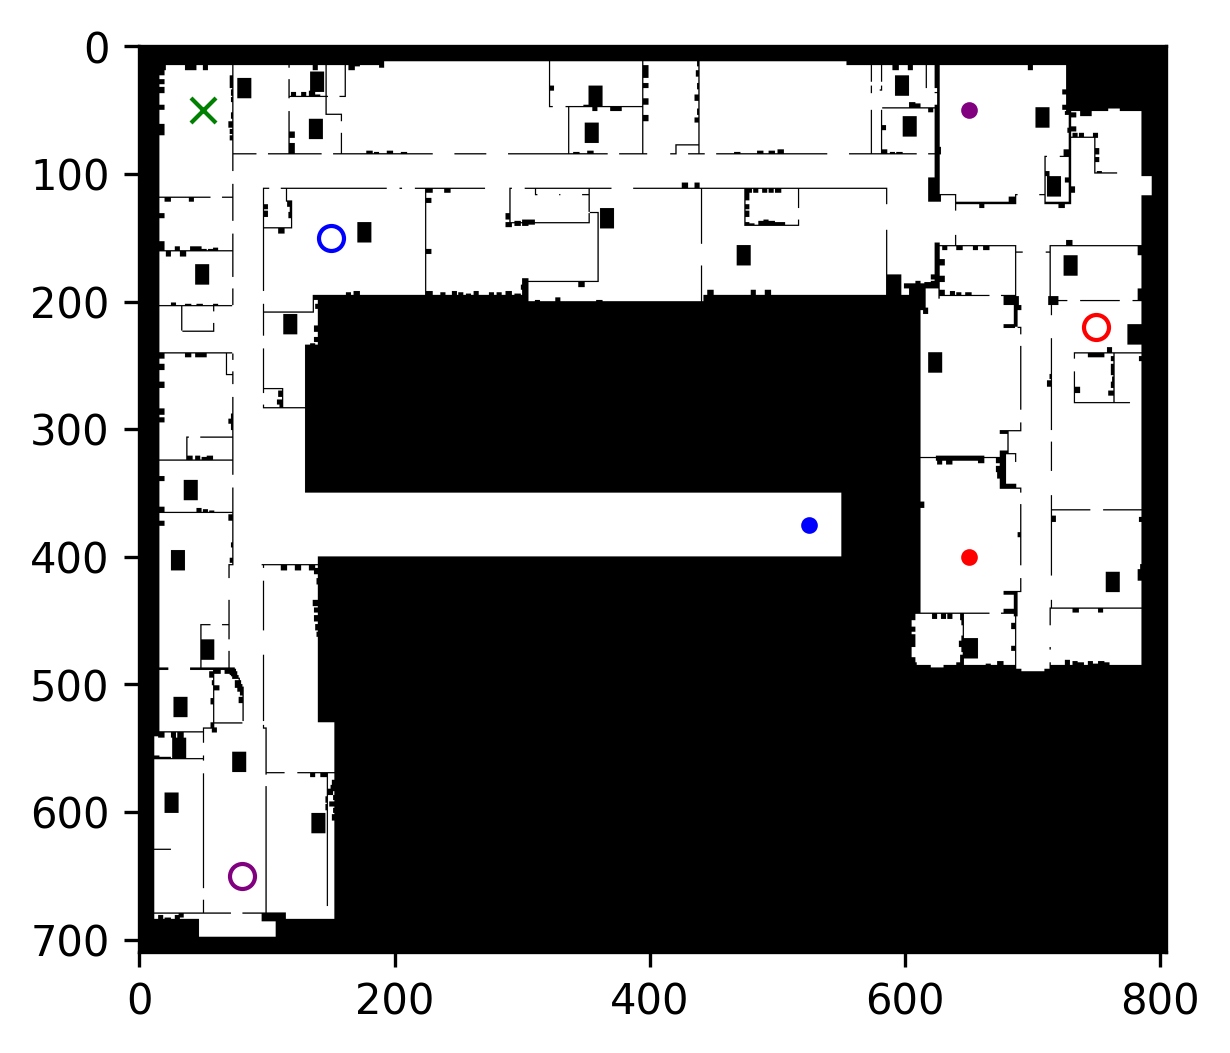

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

def plot_map_with_pois(map_data):
    plt.figure(dpi=300)
    plt.imshow(1 - map_data['occ_grid'].T, cmap='gray')
    plt.plot(map_data['start'][0], map_data['start'][1], 'xg')
    plt.plot(map_data['red-key-1'][0], map_data['red-key-1'][1], '.r')
    plt.plot(map_data['red-vault-1'][0], map_data['red-vault-1'][1], 'or', fillstyle='none')
    plt.plot(map_data['blue-key-1'][0], map_data['blue-key-1'][1], '.b')
    plt.plot(map_data['blue-vault-1'][0], map_data['blue-vault-1'][1], 'ob', fillstyle='none')
    plt.plot(map_data['purple-key-1'][0], map_data['purple-key-1'][1], '.', color='purple')
    plt.plot(map_data['purple-vault-1'][0], map_data['purple-vault-1'][1], 'o', color='purple', fillstyle='none')


map_data = pickle.load(open("1-0_1030_data.pickle", "rb"))
map_data['occ_grid'][100:550, 350:400] = 0
map_data['start'] = [50, 50]
map_data['red-key-1'] = [650, 400]
map_data['red-vault-1'] = [750, 220]
map_data['blue-key-1'] = [525, 375]
map_data['blue-vault-1'] = [150, 150]
map_data['purple-key-1'] = [650, 50]
map_data['purple-vault-1'] = [80, 650]

plot_map_with_pois(map_data)


#### code collapse

In [ ]:
import skimage.graph
cost_grid = 1000*map_data['occ_grid'] + 1

mcp = skimage.graph.MCP_Geometric(cost_grid)
# goal_dis_cost_grid = mcp.find_costs(starts=[[goal_pose.x, goal_pose.y]])[0]
# distance = goal_dis_cost_grid[int(robot_pose.x), int(robot_pose.y)]

# distance between start and red-key
goal_dis_cost_grid = mcp.find_costs(starts=[[650, 400]])[0]
dis_start_red_key = goal_dis_cost_grid[int(50), int(50)]
print("Distance between the start poitn and red-key")
print(dis_start_red_key)

# distance between start and blue-key
goal_dis_cost_grid = mcp.find_costs(starts=[[525, 375]])[0]
distance = goal_dis_cost_grid[int(50), int(50)]
print("Distance between the start poitn and blue-key")
print(distance)

# distance between start and purple-key
goal_dis_cost_grid = mcp.find_costs(starts=[[650, 50]])[0]
distance = goal_dis_cost_grid[int(50), int(50)]
print("Distance between the start poitn and purple-key")
print(distance)

# distance between start and blue-vault
goal_dis_cost_grid = mcp.find_costs(starts=[[150, 150]])[0]
distance = goal_dis_cost_grid[int(50), int(50)]
print("Distance between the start poitn and blue-vault")
print(distance)

# distance between start and red-vault
goal_dis_cost_grid = mcp.find_costs(starts=[[750, 220]])[0]
distance = goal_dis_cost_grid[int(50), int(50)]
print("Distance between the start poitn and red-vault")
print(distance)

# distance between start and purple-vault
goal_dis_cost_grid = mcp.find_costs(starts=[[80, 650]])[0]
distance = goal_dis_cost_grid[int(50), int(50)]
print("Distance between the start poitn and purple-vault")
print(distance)

# distance between blue-key and purple-key
goal_dis_cost_grid = mcp.find_costs(starts=[[650, 50]])[0]
distance = goal_dis_cost_grid[525, 375]
print("Distance between the purple-key and blue-key")
print(distance)

# distance between blue-key and red-key
goal_dis_cost_grid = mcp.find_costs(starts=[[650, 400]])[0]
distance = goal_dis_cost_grid[525, 375]
print("Distance between the blue-key and red-key")
print(distance)

# distance between blue-key and blue-vault
goal_dis_cost_grid = mcp.find_costs(starts=[[150, 150]])[0]
distance = goal_dis_cost_grid[525, 375]
print("Distance between the blue-key and blue-vault")
print(distance)

# distance between blue-key and red-vault
goal_dis_cost_grid = mcp.find_costs(starts=[[750, 220]])[0]
distance = goal_dis_cost_grid[525, 375]
print("Distance between the blue-key and red-vault")
print(distance)

# distance between blue-key and purple-vault
goal_dis_cost_grid = mcp.find_costs(starts=[[80, 650]])[0]
distance = goal_dis_cost_grid[525, 375]
print("Distance between the blue-key and purple-vault")
print(distance)

# distance between red-key and purple-key
goal_dis_cost_grid = mcp.find_costs(starts=[[650, 400]])[0]
distance = goal_dis_cost_grid[650, 50]
print("Distance between the red-key and purple-key")
print(distance)

# distance between red-key and purple-vault
goal_dis_cost_grid = mcp.find_costs(starts=[[650, 400]])[0]
distance = goal_dis_cost_grid[80, 650]
print("Distance between the red-key and purple-vault")
print(distance)

# distance between red-key and red-vault
goal_dis_cost_grid = mcp.find_costs(starts=[[650, 400]])[0]
distance = goal_dis_cost_grid[750, 220]
print("Distance between the red-key and red-vault")
print(distance)

# distance between red-key and blue-vault
goal_dis_cost_grid = mcp.find_costs(starts=[[650, 400]])[0]
distance = goal_dis_cost_grid[150, 150]
print("Distance between the red-key and blue-vault")
print(distance)

# distance between purple-key and blue-vault
goal_dis_cost_grid = mcp.find_costs(starts=[[650, 50]])[0]
distance = goal_dis_cost_grid[150, 150]
print("Distance between the purple-key and blue-vault")
print(distance)

# distance between purple-key and red-vault
goal_dis_cost_grid = mcp.find_costs(starts=[[650, 50]])[0]
distance = goal_dis_cost_grid[750, 220]
print("Distance between the purple-key and red-vault")
print(distance)

# distance between purple-key and purle-vault
goal_dis_cost_grid = mcp.find_costs(starts=[[650, 50]])[0]
distance = goal_dis_cost_grid[80, 650]
print("Distance between the purple-key and purple-vault")
print(distance)

# distance between red_vault and purle-vault
goal_dis_cost_grid = mcp.find_costs(starts=[[750, 220]])[0]
distance = goal_dis_cost_grid[80, 650]
print("Distance between the red-vault and purple-vault")
print(distance)

# distance between red-vault and blue-vault
goal_dis_cost_grid = mcp.find_costs(starts=[[750, 220]])[0]
distance = goal_dis_cost_grid[150, 150]
print("Distance between the red-vault and blue-vault")
print(distance)

# distance between purple-vault and blue-vault
goal_dis_cost_grid = mcp.find_costs(starts=[[80, 650]])[0]
distance = goal_dis_cost_grid[150, 150]
print("Distance between the purple-vault and blue-vault")
print(distance)


# map_data['blue-vault-1'] = [150, 150]
# map_data['purple-vault-1'] = [80, 650]

Distance between the start poitn and red-key
959.0193359837571
Distance between the start poitn and blue-key
738.4924240491758
Distance between the start poitn and purple-key
776.0071426749369
Distance between the start poitn and blue-vault
231.86500705120557
Distance between the start poitn and red-vault
801.4629867976527
Distance between the start poitn and purple-vault
615.7401153701779
Distance between the purple-key and blue-key
1299.369624409202
Distance between the blue-key and red-key
1482.3818177180221
Distance between the blue-key and blue-vault
642.9777054234141
Distance between the blue-key and red-vault
1324.8254685319177
Distance between the blue-key and purple-vault
693.0538238691627
Distance between the red-key and purple-key
384.7939392393404
Distance between the red-key and purple-vault
1369.5706345359786
Distance between the red-key and red-vault
221.42135623730957
Distance between the red-key and blue-vault
839.4041122946074
Distance between the purple-key and blue-

### P5.4.3

The scenario here is very similar to that from the previous question: there are three vaults (open circles) you can unlock and three keys (closed circles) that you need to pick up to unlock them. However, unlike before, I have not told you the costs associated with movement! You will need to compute those yourself (using any of the code from previous assignments) and then input those distances into PDDL.

**TASK** Adapt the PDDL scenario from the previous question for this scenario. Note that, while the locations are not "named", the position of the robot, keys, and vaults are "points of interest" that you will need to define. Feel free to make your own names of the locations.

**CODE** Include a screenshot of your PDDL "domain" definition for this problem.

**TASK** Compute the distances you will need (using whatever code you would like from previous assignments). Include those in your PDDL.

> Note: technically the "cost" of motion will require simulating the vehicle dynamics. Feel free to ignore this when computing the distances; an approximate value (e.g., via Scikit's `skimage.graph.MCP_Geometric`) is acceptable.

> Note: the way that FastDownward's solver works, float values are not accepted. Round the distances to the nearest int.

> Note: make sure you compute the distances using the grid! If you use Euclidian distance you will not get the correct answers.



Since there are quite a few of these distances, try to print out the exact line of PDDL you will need to include in the problem definition so that you can just copy-paste them into the PDDL code.

Given some objective, PDDL will return a plan that you will then turn into a series of coordinates for a simulated differential drive robot to follow.

**TASK** Write a function (in Python) that takes in a series of waypoints and the occupancy grid and simulates the trajectory of a differential drive robot (the one from P2) following those sequence of waypoints. [A waypoint is "reached" when the robot is within 5 pixels of it.] You will need this function to "follow" the plan from PDDL: when PDDL returns a plan, you will turn that plan into a sequence of coordinates for the robot to reach thus simulating the executation of the plan you have found.

**RESULTS/PLOTS** I have provided you with a few PDDL goal specifications. **For each**:
- Input that goal specification (or equiavalent) into PDDL and solve. Include the resulting plan (and its cost) in your writeup.
- Input the coordinates from that plan into your navigation function above. Simulate the differential drive robot following the plan. Make a plot that shows the trajectory of a robot following the plan and include it in your writeup. Include also the cost of that trajectory.

I will look at both the plan and the trajectory to evaluate your grade. Make sure the plan and accompanying trajectory seem reasonable! The robot should accomplish the specification in minimum time. Your trajectory should reach all the places you think you need to have reached.

Speficiations:
1. `(at robot red-vault-1-location)` Robot is at the red vault
2. `(unlocked red-vault-1)` Robot has unlocked the red vault
3. `(and (at robot start-location) (unlocked red-vault-1))` Robot has unlocked the red vault and returned to the start
4. `(and (at robot start-location) (unlocked red-vault-1) (unlocked blue-vault-1) (unlocked purple-vault-1))` Robot has unlocked all three vaults and returned to the start

In [ ]:
from p2core import RobotState, plot_robot_state, Pose, primitive_library
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt
import skimage.graph
from sortedcontainers import SortedList

def astar_search(robot, goal_pose, cost_grid, primitives, heuristic_fn=None, num_steps=1000):
    final_rstate = None
    start_rstate = RobotState(Pose(robot.pose.x, robot.pose.y, robot.pose.yaw))
    if heuristic_fn is None:
        rstates = SortedList([start_rstate], 
                key=lambda rs: rs.net_motion)
    else:
        rstates = SortedList([start_rstate], 
                     key=lambda rs: rs.net_motion + heuristic_fn(rs.pose, goal_pose))

    # Run search
    for counter in range(num_steps):
        # Get the one closest to the goal and remove
        # (SortedList provides this functionality)
        rstate_to_expand = rstates.pop(0)

        # If the goal is reached, we're done.
        if Pose.cartesian_distance(rstate_to_expand.pose, goal_pose) < 2:
            # print("Goal found")
            # print(f"Num steps: {counter}")
            return rstate_to_expand, rstates
    
        # Get expansions
        expansions = [rstate_to_expand.move(primitive, cost_grid=cost_grid) 
                      for primitive in primitives]
        rstates += expansions
        
    # Return the best of the remaining states
    final_rstate = rstates.pop(0)
    return final_rstate, rstates

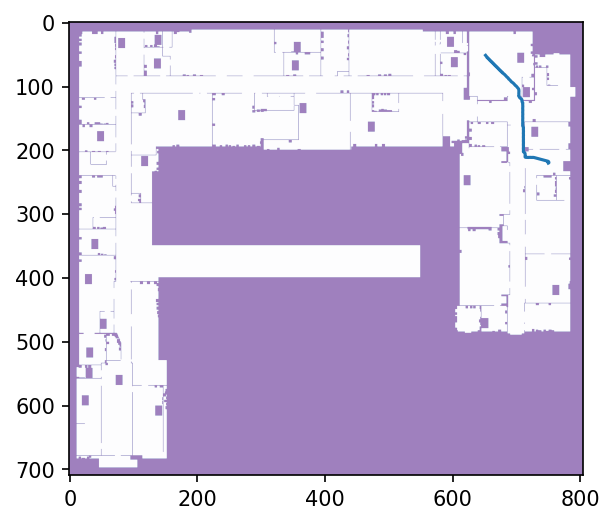

In [ ]:

map_data = pickle.load(open("1-0_1030_data.pickle", "rb"))
map_data['occ_grid'][100:550, 350:400] = 0
map_data['start'] = [50, 50]
map_data['red-key-1'] = [650, 400]
map_data['red-vault-1'] = [750, 220]
map_data['blue-key-1'] = [525, 375]
map_data['blue-vault-1'] = [150, 150]
map_data['purple-key-1'] = [650, 50]
map_data['purple-vault-1'] = [80, 650]

# print(map_data['start'])
text_1 = 'red-vault-1'
text_2 = 'purple-key-1'
start_x = map_data[text_1][0]
start_y = map_data[text_1][1]
goal_x = map_data[text_2][0]
goal_y = map_data[text_2][1]

start_pose = Pose(start_x, start_y, 0)
robot = RobotState(start_pose)
goal_pose = Pose(goal_x, goal_y, yaw=0)

cost_grid = 1000*map_data['occ_grid'] + 1
mcp = skimage.graph.MCP_Geometric(cost_grid)
goal_distance_cost_grid = mcp.find_costs(starts=[[goal_pose.x, goal_pose.y]])[0]

def heuristic_fn_cost_grid(robot_pose, goal_pose):
    return 1.1*goal_distance_cost_grid[int(robot_pose.x), int(robot_pose.y)]

while True:
    final_rstate, rstates = astar_search(
        robot, goal_pose, cost_grid, primitive_library, 
        heuristic_fn=heuristic_fn_cost_grid, num_steps=50)
    try:
        robot.move_along_rstate(final_rstate)
    except AttributeError:
        break

# Plot the map and start state
plt.figure(dpi=150)
ax = plt.gca()
plot_robot_state(ax, robot)
ax.imshow(cost_grid.T, alpha=0.5, cmap='Purples')
ax.set_aspect('equal', adjustable='box')

# Now we plot the results
# for rstate in rstates:
#     print(rstate)
#     plot_robot_state(ax, rstate, False, alpha=0.1)

# get the trajectory
traj_x = [pose.x for pose in robot.all_poses]
traj_y = [pose.y for pose in robot.all_poses]


In [ ]:
class DiffDrive(object):
    def __init__(self, init_x, init_y, width=0.1, error_std=0, max_spin=1):
        self.pos_x = init_x
        self.pos_y = init_y
        self.theta = 0
        self.width = 0.1
        self.max_spin = max_spin
        self.vel = 0
        self.error_std = error_std
        
        self.states = [[self.pos_x, self.pos_y, self.theta]]
    
    def command(self, vl, vr):
        if np.abs(vl) > self.max_spin:
            vl = vl / np.abs(vl)
        if np.abs(vr) > self.max_spin:
            vr = vr / np.abs(vr)
            
        self.vl = vl
        self.vr = vr
        # self.vel += u
        
    def advance_time(self, dt):
        # Error in the velocity
        
        if np.abs(self.vr - self.vl) < 0.0001:
            # Robot moves in a straight line
            self.pos_x += self.vr * dt * np.cos(self.theta)
            self.pos_y += self.vr * dt * np.sin(self.theta)
            self.states.append([self.pos_x, self.pos_y, self.theta])
            return
        
        R = self.width / 2 * (self.vl + self.vr) / (self.vr - self.vl)
        omega = (self.vr - self.vl) / self.width
        # Instantaneous Center of Curvature (ICC)
        ICCx = self.pos_x - R * np.sin(self.theta)
        ICCy = self.pos_y + R * np.cos(self.theta)
        
        domega = omega * dt

        updated_state = np.array([
            [np.cos(domega), -np.sin(domega), 0],
            [np.sin(domega), np.cos(domega), 0],
            [0, 0, 1]
        ]) @ np.array([
            [self.pos_x - ICCx],
            [self.pos_y - ICCy],
            [self.theta]
        ]) + np.array([
            [ICCx],
            [ICCy],
            [domega]
        ])

        self.pos_x = updated_state[0, 0]
        self.pos_y = updated_state[1, 0]
        self.theta = updated_state[2, 0]
        
        self.states.append([self.pos_x, self.pos_y, self.theta])
        
    def visualize_trajectory(self):
        points = np.array(self.states)
        plt.plot(points[:, 0], points[:, 1], '.-')
        plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
def simple_diff_drive_controller(car, gx, gy, K_theta, K_vel, dt=0.5):
    # gx is the goal x position
    # gy is the goal y position
    for t in np.arange(0, 100, dt):
        theta_rel = np.arctan2(gy - car.pos_y, gx - car.pos_x) - car.theta
        theta_rel = theta_rel % (2 * np.pi)
        if theta_rel > np.pi:
            theta_rel -= 2 * np.pi
            
        dist = np.sqrt(
            (gy - car.pos_y) ** 2 + (gx - car.pos_x) ** 2
        )
        if dist < 4:
          break
        
        vl = K_vel * dist - K_theta * theta_rel
        vr = K_vel * dist + K_theta * theta_rel

        car.command(vl, vr)
        car.advance_time(dt)
    
    return car.states

In [ ]:
def follow_a_trajectory(car, x,y):
  for i in range(len(x)):
    simple_diff_drive_controller(car, x[i], y[i], K_theta=0.025, K_vel=0.05)

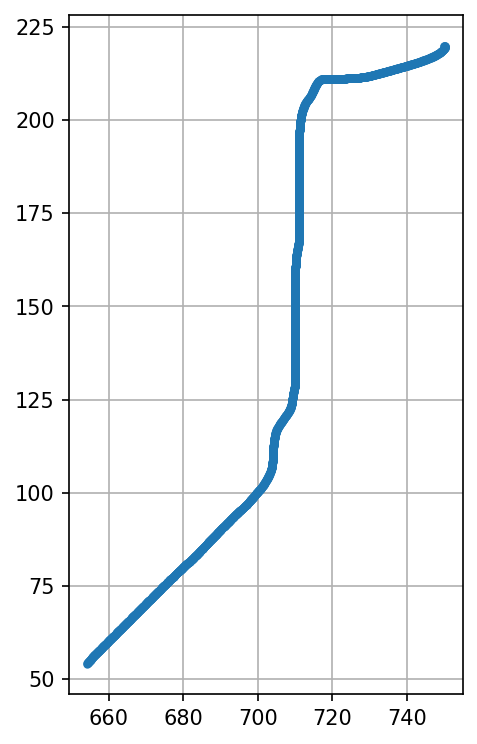

In [ ]:
plt.figure(figsize=(6, 6), dpi=150)
plt.grid()
car = DiffDrive(start_x, start_y)
follow_a_trajectory(car, traj_x, traj_y)
car.visualize_trajectory()